<a href="https://colab.research.google.com/github/sinahuss/solar-flare-prediction/blob/main/notebooks/solar_flare_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Note for Colab Users

- **For quick exploration**: Review the pre-computed outputs without re-running
- **For full execution**: Run all cells (~8 minutes on Colab CPU)
- **Prediction interface**: All cells must be fully executed, then jump to Section 6.1.


# **C964 Capstone: Solar Flare Prediction and Analysis**


## 1. Business Understanding


### 1.1. Organizational Need

Space weather events, particularly solar flares, pose significant risks to critical infrastructure on Earth and in space. Organizations like NOAA's Space Weather Prediction Center require reliable early warning systems to protect:

- Satellite communications and GPS systems
- Power grids
- Astronauts and aircraft
- Radio communications

Current prediction methods rely heavily on human expertise and limited historical patterns, which may result in missed events or false alarms. These risks can lead to potentially billions of dollars in economic damage and disruptions to essential services.

### 1.2. Project Goal

This project aims to develop a data product featuring a machine learning model that can predict the likelihood of solar flare events (C, M, or X class) within a 24-hour period based on characteristics of sunspot regions. The model will provide early warning capability for space weather forecasters, and improved accuracy in flare prediction to reduce false alarms and missed events

### 1.3. Success Criteria

Missing an X-class flare (false negative) is far more costly than incorrectly predicting one (false positive), so at least 60% recall for severe flares is our primary optimization target.


## 2. Data Understanding


### 2.1. Load Libraries and Data

Our solar flare prediction analysis begins with importing essential libraries and loading the sunspot dataset.

The dataset will be loaded from a public GitHub repository containing the Solar Flare Dataset from Kaggle, which provides the historical data needed to train our flare prediction model.

This dataset contains morphological characteristics of sunspot groups that solar physicists use to assess flare potential. The first few rows will be displayed to verify successful data loading and provide an initial glimpse of the sunspot characteristics.


In [1]:
# Core libraries
import numpy as np
import pandas as pd

# Data visualization
from matplotlib import (
    pyplot as plt,
    cm,
)
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Machine learning preprocessing and model selection
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.utils.class_weight import compute_class_weight

# Machine learning algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Model evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)

# Handling imbalanced datasets
from imblearn.combine import SMOTEENN

# Model interpretability
import shap

# Import ipywidgets for interactive interface
import ipywidgets as widgets
from IPython.display import display, HTML

# Ignore warnings
import warnings

warnings.filterwarnings("ignore")

# Load dataset from GitHub repository (public Kaggle dataset)
url = "https://raw.githubusercontent.com/sinahuss/solar-flare-prediction/refs/heads/main/data/data.csv"
df = pd.read_csv(url)

# Display first few rows to verify successful loading
display(df.head())

/home/sinahuss/miniconda3/envs/cenv/lib/python3.13/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


,modified Zurich class,largest spot size,spot distribution,activity,evolution,previous 24 hour flare activity,historically-complex,became complex on this pass,area,area of largest spot,common flares,moderate flares,severe flares
0,C,S,O,1,2,1,1,2,1,2,0,0,0
1,D,S,O,1,3,1,1,2,1,2,0,0,0
2,C,S,O,1,3,1,1,2,1,1,0,0,0
3,D,S,O,1,3,1,1,2,1,2,0,0,0
4,D,A,O,1,3,1,1,2,1,2,0,0,0


### 2.2. Dataset Feature Descriptions

The dataset contains 13 features describing each solar active region. The first 10 are the input features for our model, and the last three are the target variables we aim to predict.

**Input Features:**

- `modified Zurich class`: A classification of the sunspot group's magnetic complexity, generally ordered from least to most complex (A, B, C, D, E, F, H).
- `largest spot size`: Size of the largest spot in the group, ordered from smallest to largest (X, R, S, A, H, K).
- `spot distribution`: Compactness of the sunspot group, ordered from least to most compact (X, O, I, C).
- `activity`: A code representing the region's recent growth (1=decay, 2=no change).
- `evolution`: Describes the region's evolution over the last 24 hours (1=decay, 2=no growth, 3=growth).
- `previous 24 hour flare activity`: A code summarizing prior flare activity (1=none, 2=one M1, 3=>one M1).
- `historically-complex`: A flag indicating if the region was ever historically complex (1=Yes, 2=No).
- `became complex on this pass`: A flag indicating if the region became complex on its current transit (1=Yes, 2=No).
- `area`: A code for the total area of the sunspot group (1=small, 2=large).
- `area of largest spot`: A code for the area of the largest individual spot (1=<=5, 2=>5).

Target Variables:

- `common flares`: The number of C-class flares produced in the next 24 hours.
- `moderate flares`: The number of M-class flares produced in the next 24 hours.
- `severe flares`: The number of X-class flares produced in the next 24 hours.


### 2.3. Initial Data Inspection

A foundational understanding of the dataset's structure and quality must be established. This inspection is critical for the solar flare prediction model because data quality directly impacts model performance and reliability for space weather forecasting.

First, we will use `.info()` to examine the column names, data types, and check for any missing values. The output confirms that there are no missing values, meaning that null values do not have to be accounted for in the data preparation phase.

Next, we use `describe()` to generate a summary of the categorical features, including their unique values and most frequent entries, which helps us understand the distribution and composition of the dataset's categorical variables.


In [2]:
df.info()

df.astype("object").describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1389 entries, 0 to 1388
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   modified Zurich class            1389 non-null   object
 1   largest spot size                1389 non-null   object
 2   spot distribution                1389 non-null   object
 3   activity                         1389 non-null   int64 
 4   evolution                        1389 non-null   int64 
 5   previous 24 hour flare activity  1389 non-null   int64 
 6   historically-complex             1389 non-null   int64 
 7   became complex on this pass      1389 non-null   int64 
 8   area                             1389 non-null   int64 
 9   area of largest spot             1389 non-null   int64 
 10  common flares                    1389 non-null   int64 
 11  moderate flares                  1389 non-null   int64 
 12  severe flares                    1

,count,unique,top,freq
modified Zurich class,1389,6,H,396
largest spot size,1389,6,S,514
spot distribution,1389,4,O,627
activity,1389,2,1,1180
evolution,1389,3,3,680
previous 24 hour flare activity,1389,3,1,1320
historically-complex,1389,2,1,839
became complex on this pass,1389,2,2,1239
area,1389,2,1,1353
area of largest spot,1389,2,1,1145


### 2.4. Exploratory Data Analysis


#### 2.4.1. Target Variable Analysis

Before analyzing the input features, we must first understand the distribution of our target variables: `common flares`, `moderate flares`, and `severe flares`. The plots below show the number of 24-hour periods in the dataset that recorded zero, one, or more flares of each type.

**Key Findings:**

The visualization reveals a severe class imbalance for our solar flare prediction. Out of all 24-hour periods available, only 16% experienced at least one C-Class event, 5% recorded M-Class events, and 1% showed X-Class events.

This imbalance has implications for our machine learning approach:

- **Sampling Strategy:** We may need to employ techniques like stratified sampling and SMOTE (Synthetic Minority Oversampling Technique) to address the imbalance.

- **Evaluation Metrics:** The model's success will be measured primarily by the macro f1 score rather than overall accuracy, because it places greater emphasis on rare X class flares, which are the most impactful.


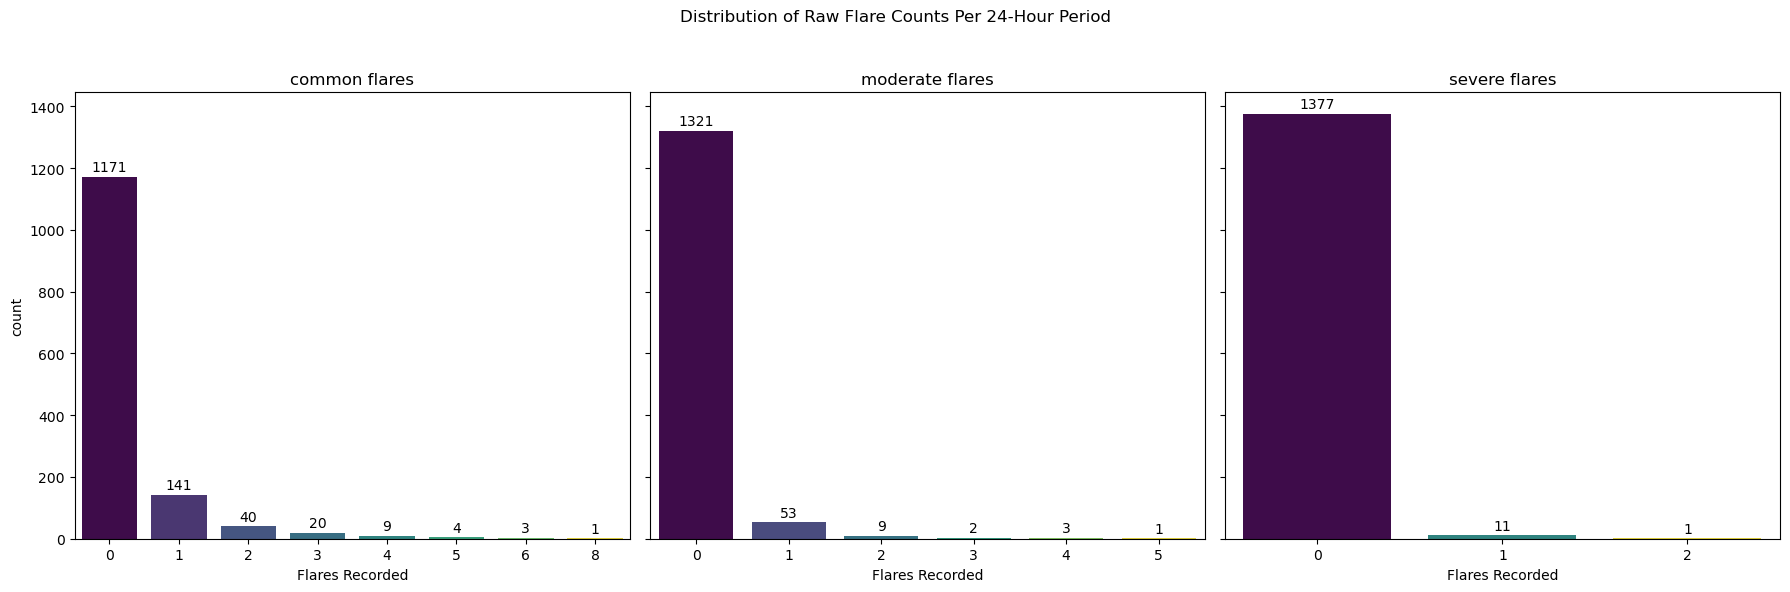

In [3]:
flare_columns = ["common flares", "moderate flares", "severe flares"]

# Create a figure with 3 subplots, one for each flare type
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle("Distribution of Raw Flare Counts Per 24-Hour Period")

# Loop through each flare type and plot its distribution
for i, col in enumerate(flare_columns):
    ax = axes[i]
    countplot = sns.countplot(
        data=df, x=col, ax=ax, hue=col, palette="viridis", legend=False
    )
    ax.set_title(f"{col}")
    ax.set_xlabel("Flares Recorded")
    for container in ax.containers:
        ax.bar_label(container, fmt="%d", label_type="edge", padding=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### 2.4.2. Relationship Analysis

We now explore the relationship between flare production and `modified Zurich class` through two visualizations. These analyses investigate a key hypothesis: that more complex sunspot groups produce more significant flares.

**Total Flares Analysis:** The first subplot shows the total number of C, M, and X-class flares produced by each modified Zurich class, revealing which sunspot configurations are the most prolific sources of solar flares.

**Average Flares Analysis:** The second subplot normalizes this data by showing the average number of flares per class instance, accounting for the different frequencies of each modified Zurich class in the dataset. This provides a more accurate assessment of flare risk per sunspot group.

**Key Findings:**

The two visualizations help us prioritize which modified Zurich class to observe.

- **Low-Risk:** B and C class sunspot regions are low complexity and produce the least amount of solar flares, so they can be seen as low-risk regions. H class regions are decayed remnants of C, D, E, and F regions, and are also low-risk regions.

- **Medium-Risk:** D class sunspot regions are interesting because they produce the highest number of total solar flares in the dataset. But, after normalizing the data, we can see that they actually produce significantly fewer flares per sunspot region. Therefore, they can be categorized as medium-risk regions.

- **High-Risk:** E class regions are almost guaranteed to produce solar flares, reaching just under 1 C-Class solar flare per instance. F class regions produce a low total amount of solar flares, but adjusting for their lower representation in the dataset, they produce a high number of solar flares per region. F class regions also produce the highest amount of X-class (severe) flares when data is normalized.


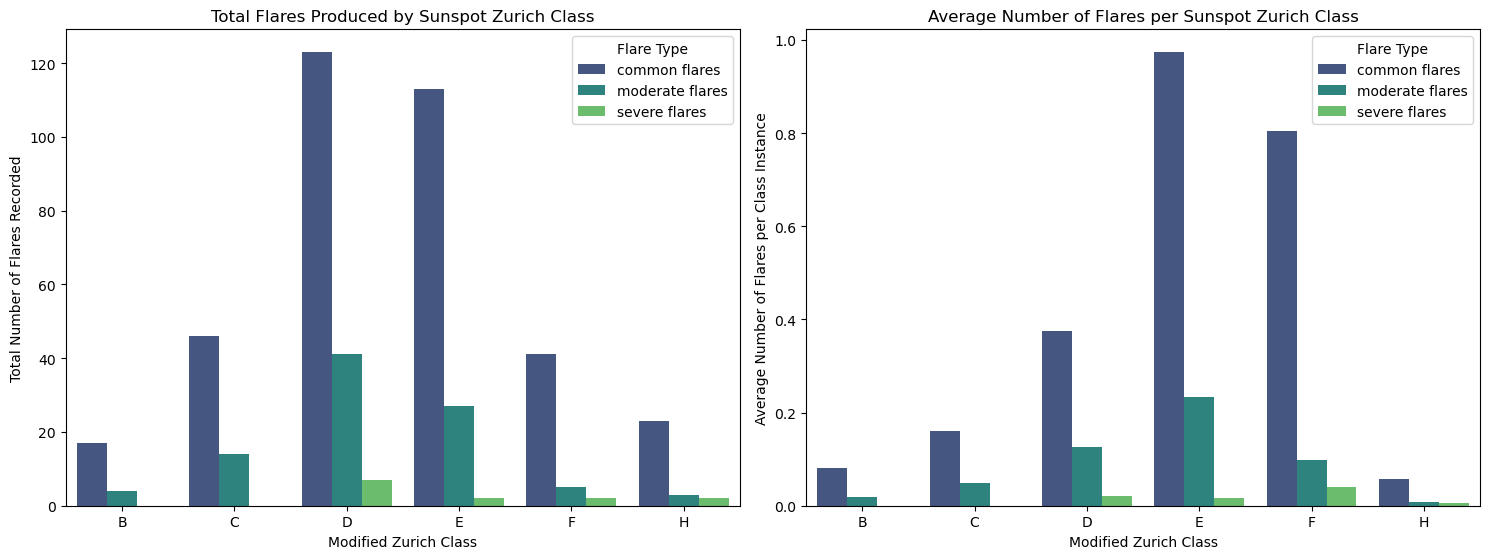

In [4]:
# Melt the dataframe to have a single column for flare type and another for the count
flare_counts_df = df.melt(
    id_vars=["modified Zurich class"],
    value_vars=["common flares", "moderate flares", "severe flares"],
    var_name="flare_type",
    value_name="count",
)

# Specify the order for each categorical feature for consistent plotting
category_orders = {
    "modified Zurich class": ["B", "C", "D", "E", "F", "H"],
    "largest spot size": ["X", "R", "S", "A", "H", "K"],
    "spot distribution": ["X", "O", "I", "C"],
}

# Remove rows where flares have not occurred
flare_counts_df = flare_counts_df[flare_counts_df["count"] > 0]

# Calculate the number of sunspot groups for each Zurich class
zurich_class_counts = df["modified Zurich class"].value_counts().to_dict()

# Calculate the proportional number of flares (per Zurich class instance)
flare_counts_df["class_count"] = flare_counts_df["modified Zurich class"].map(
    zurich_class_counts
)
flare_counts_df["count_per_class"] = (
    flare_counts_df["count"] / flare_counts_df["class_count"]
)

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Create the Grouped Bar Plot
sns.barplot(
    data=flare_counts_df,
    x="modified Zurich class",
    y="count",
    hue="flare_type",
    estimator=sum,
    order=category_orders["modified Zurich class"],
    palette="viridis",
    errorbar=None,
    ax=ax1,
)
ax1.set_title("Total Flares Produced by Sunspot Zurich Class")
ax1.set_xlabel("Modified Zurich Class")
ax1.set_ylabel("Total Number of Flares Recorded")
ax1.legend(title="Flare Type")

# Second subplot: Average Flares per Class Instance
sns.barplot(
    data=flare_counts_df,
    x="modified Zurich class",
    y="count_per_class",
    hue="flare_type",
    estimator=sum,
    order=category_orders["modified Zurich class"],
    palette="viridis",
    errorbar=None,
    ax=ax2,
)
ax2.set_title("Average Number of Flares per Sunspot Zurich Class")
ax2.set_xlabel("Modified Zurich Class")
ax2.set_ylabel("Average Number of Flares per Class Instance")
ax2.legend(title="Flare Type")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### 2.4.3. Multi-dimensional Risk Analysis

This analysis examines how combinations of `largest spot size` and `spot distribution` patterns can contribute to flare risk, providing insights into the physical characteristics that drive solar flare activity.

**Key Findings from 3D Risk Analysis:**

Some combinations have lower sample size for reliable assessment. However, a general risk escalation from small, dispersed (X-X) to large, compact (K-C) configurations can be seen. Large, compact spot configurations (K-C, K-I combinations) show the highest risk scores, confirming that both `largest spot size` and `spot distribution` are critical factors, with their interaction creating non-linear risk patterns.


In [5]:
# Establish category order for plotting
spot_sizes = category_orders["largest spot size"]
distributions = category_orders["spot distribution"]

# Create meshgrids for 3D plotting
X_grid, Y_grid = np.meshgrid(spot_sizes, distributions)

# Calculate average flare risk score for each combination
Z_grid = np.zeros_like(X_grid, dtype=float)
count_grid = np.zeros_like(X_grid, dtype=int)
for i, spot_size in enumerate(spot_sizes):
    for j, distribution in enumerate(distributions):
        # Use exact matching for both spot size and distribution
        mask = (df["largest spot size"] == spot_size) & (
            df["spot distribution"] == distribution
        )
        count = mask.sum()
        count_grid[j, i] = count
        if count > 0:
            risk_scores = (
                df.loc[mask, "common flares"].fillna(0) * 1
                + df.loc[mask, "moderate flares"].fillna(0) * 2
                + df.loc[mask, "severe flares"].fillna(0) * 3
            )
            Z_grid[j, i] = risk_scores.mean()

# Add the main risk surface
fig = go.Figure(
    data=[
        go.Surface(
            x=X_grid,
            y=Y_grid,
            z=Z_grid,
            customdata=np.stack((X_grid.T, Y_grid.T, count_grid.T), axis=-1),
            colorscale="Reds",
            hovertemplate="<b>Spot Size: %{x}<br>"
            + "<b>Distribution: %{y}<br>"
            + "<b>Average Flare Risk: %{z:.2f}<br>"
            + "<b>Sample Size: %{customdata[2]}<extra></extra>",
            opacity=0.9,
        )
    ]
)

# Show the figure
fig.update_layout(
    title="3D Surface: Flare Risk by Spot Size and Distribution",
    scene=dict(
        xaxis_title="Largest Spot Size",
        yaxis_title="Spot Distribution",
        zaxis=dict(
            title="Risk Score",
            showticklabels=False,
        ),
        camera=dict(eye=dict(x=-1.5, y=-2, z=1.5)),
    ),
    height=700,
    width=1000,
)
fig.show()

## 3. Data Preparation



### 3.1. Feature Engineering

The dataset tracks C, M, and X class flares in three separate columns, representing the count of each event type. For this classification task, a single target variable is needed. A new column will be created called `flare_class` that categorizes each sunspot region by the most significant flare it has produced.

The original flare columns are dropped to prevent data leakage. This step ensures that the model will be trained on features that are predictive rather than features that contain information about the target variable itself.

In [6]:
# Determine the highest flare class for each row
def get_flare_class(row):
    if row["severe flares"] > 0:
        return 3  # X-class
    elif row["moderate flares"] > 0:
        return 2  # M-class
    elif row["common flares"] > 0:
        return 1  # C-class
    else:
        return 0  # None


# Create a new target column
df["flare_class"] = df.apply(get_flare_class, axis=1)

# Drop original flare columns to prevent data leakage
df.drop(columns=["common flares", "moderate flares", "severe flares"], inplace=True)

# Display the first few rows of the dataframe
display(df.head())

,modified Zurich class,largest spot size,spot distribution,activity,evolution,previous 24 hour flare activity,historically-complex,became complex on this pass,area,area of largest spot,flare_class
0,C,S,O,1,2,1,1,2,1,2,0
1,D,S,O,1,3,1,1,2,1,2,0
2,C,S,O,1,3,1,1,2,1,1,0
3,D,S,O,1,3,1,1,2,1,2,0
4,D,A,O,1,3,1,1,2,1,2,0


### 3.2. Data Preprocessing

The dataset requires preprocessing to prepare it for machine learning algorithms. This preprocessing phase is critical for solar flare prediction because the success of our model depends heavily on how well the categorical and ordinal features are transformed into numerical representations that preserve their inherent relationships and meaning.

**Key Preprocessing Steps:**

- **Ordinal Encoding:** `largest spot size` and `spot distribution` are converted to numerical scales (1-6 and 1-4 respectively) that preserve their inherent ordering from least to most large/compact.

- **Binary Feature Standardization:** Five features are binary and converted to standard 0/1 encoding. This follows ML best practices and ensures intuitive interpretation where higher values indicate greater complexity or size:
  - `historically-complex` and `became complex on this pass`: 0 = "no" (not complex), 1 = "yes" (complex)
  - `activity`: 0 = "decay", 1 = "no change"
  - `area` and `area of largest spot`: 0 = smaller size/area, 1 = larger size/area

- **One-Hot Encoding:** The `modified Zurich class` feature is transformed using one-hot encoding because of their nominal nature (H-class is decayed state).

In [7]:
# Define the order for each ordinal feature
largest_spot_size_order = {"X": 1, "R": 2, "S": 3, "A": 4, "H": 5, "K": 6}
spot_distribution_order = {"X": 1, "O": 2, "I": 3, "C": 4}

# Map the string categories to their ordinal values
df["largest spot size"] = df["largest spot size"].map(largest_spot_size_order)
df["spot distribution"] = df["spot distribution"].map(spot_distribution_order)

# Convert all binary categorical features to standard 0/1 encoding
df["historically-complex"] = (df["historically-complex"] == 1).astype(
    int
)  # 0=no, 1=yes
df["became complex on this pass"] = (df["became complex on this pass"] == 1).astype(
    int
)  # 0=no, 1=yes
df["activity"] = (df["activity"] == 2).astype(int)  # 0=decay, 1=no change
df["area"] = (df["area"] == 2).astype(int)  # 0=small, 1=large
df["area of largest spot"] = (df["area of largest spot"] == 2).astype(
    int
)  # 0=<=5, 1=>5

# One-hot encode the modified Zurich class feature
categorical_cols = ["modified Zurich class"]
df_encoded = pd.get_dummies(df, columns=["modified Zurich class"])

# Display the first few rows of the encoded dataframe
print("Dataset shape:", df_encoded.shape)
display(df_encoded.head())

Dataset shape: (1389, 16)


,largest spot size,spot distribution,activity,evolution,previous 24 hour flare activity,historically-complex,became complex on this pass,area,area of largest spot,flare_class,modified Zurich class_B,modified Zurich class_C,modified Zurich class_D,modified Zurich class_E,modified Zurich class_F,modified Zurich class_H
0,3,2,0,2,1,1,0,0,1,0,False,True,False,False,False,False
1,3,2,0,3,1,1,0,0,1,0,False,False,True,False,False,False
2,3,2,0,3,1,1,0,0,0,0,False,True,False,False,False,False
3,3,2,0,3,1,1,0,0,1,0,False,False,True,False,False,False
4,4,2,0,3,1,1,0,0,1,0,False,False,True,False,False,False


### 3.3. Correlation Matrix Heatmap

Understanding feature relationships is crucial for solar flare prediction model performance and scientific interpretation. The correlation matrix reveals which sunspot characteristics work together to create flare-prone conditions and help us identify redundant features.

**Key Findings:**

- **Feature Independence Assessment:** The correlation analysis demonstrates that most feature relationships are not overly strong (<0.7), indicating minimal multicollinearity concerns for our machine learning models. This validates that our feature set maintains appropriate independence, reducing the risk of redundant information that could negatively impact model performance.

- **Target Variable Insights:** The correlation analysis reveals distinct patterns in flare class prediction characteristics.

  - **Positive correlations:** `spot distribution` (0.34), `largest spot size` (0.30), and `area` (0.26) emerge as the most predictive features.
  - **Moderate correlations:** Activity-related metrics including `activity` (0.24) and `previous 24 hour flare activity` (0.19).
  - **Modified Zurich Class:** `modified Zurich class` `D`, `E`, and `F` show high correlation, while `B`, `C`, and `H` show low to no correlation. This aligns with section 2.4.2, that more complex Zurich class regions are higher risk for flare production. 



In [8]:
# Calculate correlation matrix
corr_matrix = df_encoded.corr()

# Visualize correlation matrix
fig = px.imshow(
    df_encoded.corr(),
    title="Correlation Matrix Heatmap",
    color_continuous_scale="RdBu_r",
    zmin=-1,
    zmax=1,
    labels=dict(color="correlation")
)

fig.update_layout(width=800, height=600, xaxis=dict(tickangle=-45))
fig.show()

### 3.4. Data Splitting

The data is split into a 70-30 ratio which provides sufficient training data for our models while reserving a holdout set for performance assessment.

A stratified split is used to ensure proportional representation of all flare classes across training and test sets. Given the extreme rarity of X-class flares, random splitting could result in test sets with zero X-class events, making performance evaluation impossible. 


In [9]:
# Split features and target
X = df_encoded.drop(columns=["flare_class"])
y = df_encoded["flare_class"]

# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Define class names
class_names = ["No Flare", "C-Class", "M-Class", "X-Class"]

# Display distributions after stratified split
print("Class Distribution:")
class_dist_df = pd.DataFrame(
    {
        "Original": y.value_counts().sort_index().values,
        "Train": y_train.value_counts().sort_index().values,
        "Test": y_test.value_counts().sort_index().values,
    },
    index=class_names,
)
display(class_dist_df)

Class Distribution:


,Original,Train,Test
No Flare,1130,791,339
C-Class,186,130,56
M-Class,61,43,18
X-Class,12,8,4


### 3.5. Sampling Strategy

This subsection implements sampling techniques specifically designed to improve X-class flare detection performance. Because of the extreme class imbalance in solar flare data, we want to prevent the models from simply predicting "no flare" for every case and achieving 85% accuracy.

**SMOTEENN:**

Our sampling strategy employs SMOTEENN (Synthetic Minority Oversampling Technique + Edited Nearest Neighbors), a method that addresses both the minority class shortage and majority class noise. This technique first generates synthetic examples of rare flare events using SMOTE (oversampling), then removes noisy majority class samples using ENN (undersampling).

The Random Forest and XGBoost models benefit significantly from balanced training data, as each tree in the ensemble can learn meaningful patterns from minority classes rather than being overwhelmed by the majority class.

Original shape: (972, 15), Sampled shape: (1777, 15), Amplification: 1.8x


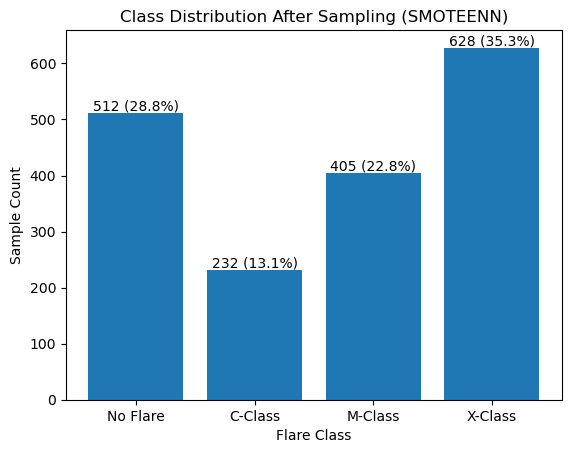

In [10]:
# Resample training data using SMOTEENN to balance the classes
sampler = SMOTEENN(random_state=42)
X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)

# Calculate class counts and amplification
final_counts = pd.Series(y_train_sampled).value_counts().sort_index()
amplification = X_train_sampled.shape[0] / X_train.shape[0]

# Print amplification
print(
    f"Original shape: {X_train.shape}, Sampled shape: {X_train_sampled.shape}, Amplification: {amplification:.1f}x"
)

# Bar plot for class distribution after sampling
plt.bar(class_names, final_counts)
plt.title("Class Distribution After Sampling (SMOTEENN)")
plt.ylabel("Sample Count")
plt.xlabel("Flare Class")
for i, v in enumerate(final_counts):
    plt.text(i, v + 5, f"{v} ({v / len(y_train_sampled) * 100:.1f}%)", ha="center")
plt.show()

## 4. Modeling


### 4.1. Model Selection

For solar flare prediction, we use three proven machine learning models:

- **Random Forest**: An ensemble of decision trees, resistant to overfitting and useful for feature importance.
- **XGBoost**: A high-performance gradient boosting method, effective for imbalanced and structured data.
- **Support Vector Machine (SVM)**: Finds optimal class boundaries and works well with class weighting.

These models are chosen for their strong performance on multi-class, imbalanced problems and their ability to capture complex relationships in the data. We will compare their results to select the best approach for predicting C, M, and X-class solar flares.


### 4.2. Hyperparameter Tuning

Hyperparameter optimization is critical for our models' success, particularly given the extreme class imbalance and high-stakes nature of missing severe flare events. The tuning utilizes either grid search or randomized search, selecting the most appropriate method based on computational complexity and parameter space size.

**Optimization Strategy:**

- **Stratified 5-fold Cross-Validation:** This technique divides the training dataset into 5 equal folds while preserving the proportional distribution of each flare class (No Flare, C-Class, M-Class, X-Class) across all folds. Regular k-fold cross-validation could create folds with zero X-class examples, making validation impossible. Stratified sampling ensures each fold contains representative samples of all classes, providing reliable performance estimates and preventing overly optimistic results from class-imbalanced test sets.

- **Class Balancing:** This strategy assigns different weights to each class during model training. Without class balancing, machine learning algorithms naturally bias toward predicting the majority class to minimize overall error, effectively ignoring rare events. We implement class weighting techniques that penalize misclassification of minority classes more heavily. This forces the model to pay equal attention to detecting rare X-class flares as it does to common cases, dramatically improving recall for severe events.

- **Scoring:** F1 macro score gives equal weight to all classes regardless of their frequency. This is essential for solar flare prediction because standard accuracy metrics would be dominated by the 85% "no flare" cases, potentially hiding poor performance on critical X-class flares. F1 macro ensures that the model's ability to detect rare X-class events receives equal consideration to predicting common events, aligning with our business objective where missing severe flares has far greater consequences than false alarms. 


#### 4.2.1. Random Forest


In [11]:
# Hyperparameter grid for Random Forest
rf_grid = {
    "n_estimators": [10, 25, 50, 100],
    "max_depth": [3, 5, 7],
    "min_samples_split": [10, 20, 50],
    "min_samples_leaf": [5, 10, 20],
    "max_features": ["sqrt", "log2"],
    "class_weight": ["balanced", "balanced_subsample", None],
}

# Set up grid search with cross-validation
rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="f1_macro",
)

# Fit Random Forest grid search on sampled training data
rf_grid_search.fit(X_train_sampled, y_train_sampled)

# Print best cross-validation score and parameters for Random Forest
print(f"RF Best CV Score: {rf_grid_search.best_score_:.4f}")
print(f"RF Best Params: {rf_grid_search.best_params_}")

RF Best CV Score: 0.9063
RF Best Params: {'class_weight': 'balanced_subsample', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}


#### 4.2.2. XGBoost


In [12]:
# Calculate class weights for XGBoost
class_weights = compute_class_weight(
    "balanced", classes=np.unique(y_train_sampled), y=y_train_sampled
)
sample_weights = np.array([class_weights[y] for y in y_train_sampled])

# Hyperparameter grid for XGBoost
xgb_grid = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [1, 2, 3],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "min_child_weight": [1, 5, 10, 20],
    "subsample": [0.9, 1],
    "colsample_bytree": [0.9, 1],
    "gamma": [5.0, 10.0],
    "reg_alpha": [0.05, 0.1, 0.5, 1.0, 2.0],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0],
}

# Set up randomized search with cross-validation
xgb_grid_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(
        random_state=42,
        eval_metric="mlogloss",
        tree_method="hist",
    ),
    param_distributions=xgb_grid,
    n_iter=50,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="f1_macro",
    random_state=42,
)

# Fit XGBoost grid search on sampled training data
xgb_grid_search.fit(
    X_train_sampled,
    y_train_sampled,
    sample_weight=sample_weights,
)

# Print best cross-validation score and parameters for XGBoost
print(f"Best XGBoost parameters: {xgb_grid_search.best_params_}")
print(f"Best cross-validation F1-macro score: {xgb_grid_search.best_score_:.4f}")

Best XGBoost parameters: {'subsample': 0.9, 'reg_lambda': 5.0, 'reg_alpha': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 5.0, 'colsample_bytree': 0.9}
Best cross-validation F1-macro score: 0.8508


#### 4.2.3. Support Vector Machine (SVM)


In [13]:
# Scale training and test data for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sampled)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter grid for SVM
svm_grid = {
    "C": [0.01, 0.1, 0.5, 1.0, 2.0],
    "kernel": ["rbf", "linear"],
    "gamma": ["scale", "auto"],
    "class_weight": ["balanced", None],
    "tol": [1e-3, 1e-4],
    "max_iter": [1000],
}

# Set up randomized search with cross-validation
svm_grid_search = RandomizedSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_distributions=svm_grid,
    n_iter=20,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="f1_macro",
    random_state=42,
)

# Fit SVM grid search on sampled training data
svm_grid_search.fit(X_train_scaled, y_train_sampled)

# Print best cross-validation score and parameters for SVM
print(f"Best SVM parameters: {svm_grid_search.best_params_}")
print(f"Best cross-validation F1-macro score: {svm_grid_search.best_score_:.4f}")

Best SVM parameters: {'tol': 0.0001, 'max_iter': 1000, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'C': 2.0}
Best cross-validation F1-macro score: 0.8801


### 4.3. Model Training

All models are trained on the SMOTEENN-balanced dataset to ensure adequate representation of rare X-class flares while maintaining data quality through noise reduction. Each algorithm uses its optimized hyperparameters from the cross-validation process, with training performance metrics calculated to establish baseline expectations before final evaluation on the holdout test set.

In [14]:
# Define function to calculate metrics
def get_metrics(y_true, y_pred, y_proba):
    metrics = {}
    metrics["Accuracy"] = accuracy_score(y_true, y_pred)
    metrics["F1-macro"] = f1_score(y_true, y_pred, average="macro")
    metrics["Recall-macro"] = recall_score(y_true, y_pred, average="macro")
    metrics["Precision-macro"] = precision_score(y_true, y_pred, average="macro")
    metrics["M-class Recall"] = recall_score(y_true, y_pred, average=None)[2]
    metrics["M-class Precision"] = precision_score(y_true, y_pred, average=None)[2]
    metrics["X-class Recall"] = recall_score(y_true, y_pred, average=None)[3]
    metrics["X-class Precision"] = precision_score(y_true, y_pred, average=None)[3]
    # ROC-AUC (macro)
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
    metrics["ROC-AUC-macro"] = roc_auc_score(
        y_true_bin, y_proba, average="macro", multi_class="ovr"
    )
    return metrics


# Define function to print metrics
def print_metrics(metrics):
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"F1-macro: {metrics['F1-macro']:.4f}")
    print(f"Recall-macro: {metrics['Recall-macro']:.4f}")
    print(f"Precision-macro: {metrics['Precision-macro']:.4f}")

#### 4.3.1. Random Forest


In [15]:
rf_model = rf_grid_search.best_estimator_

# Train the model
rf_model.fit(X_train_sampled, y_train_sampled)

# Make predictions on training set for initial assessment
rf_train_pred = rf_model.predict(X_train_sampled)
rf_train_proba = rf_model.predict_proba(X_train_sampled)

# Calculate training metrics
rf_train_metrics = get_metrics(y_train_sampled, rf_train_pred, rf_train_proba)

# Print training metrics
print("Random Forest training metrics:")
print_metrics(rf_train_metrics)

Random Forest training metrics:
Accuracy: 0.9145
F1-macro: 0.9016
Recall-macro: 0.9031
Precision-macro: 0.9047


#### 4.3.2. XGBoost


In [16]:
xgb_model = xgb_grid_search.best_estimator_

# Train the model
xgb_model.fit(X_train_sampled, y_train_sampled)

# Make predictions on training set for initial assessment
xgb_train_pred = xgb_model.predict(X_train_sampled)
xgb_train_proba = xgb_model.predict_proba(X_train_sampled)

# Calculate training metrics
xgb_train_metrics = get_metrics(y_train_sampled, xgb_train_pred, xgb_train_proba)

print("XGBoost training metrics:")
print_metrics(xgb_train_metrics)

XGBoost training metrics:
Accuracy: 0.8486
F1-macro: 0.8151
Recall-macro: 0.7959
Precision-macro: 0.8572


#### 4.3.3. Support Vector Machine (SVM)


In [17]:
svm_model = svm_grid_search.best_estimator_

# Train the model
svm_model.fit(X_train_scaled, y_train_sampled)

# Make predictions on training set for initial assessment
svm_train_pred = svm_model.predict(X_train_scaled)
svm_train_proba = svm_model.predict_proba(X_train_scaled)

# Calculate training metrics
svm_train_metrics = get_metrics(y_train_sampled, svm_train_pred, svm_train_proba)

print("SVM training metrics:")
print_metrics(svm_train_metrics)

SVM training metrics:
Accuracy: 0.9302
F1-macro: 0.9149
Recall-macro: 0.9123
Precision-macro: 0.9184


## 5. Model Evaluation


### 5.1. Performance on Holdout Set

The holdout test set evaluation shows a moderate performance. All models achieved modest F1-macro scores, with Random Forest leading at 0.471, followed by SVM (0.436) and XGBoost (0.393).

**Overfitting Analysis**

A significant performance drop between training and test sets indicates overfitting across all models. The training vs. test F1-macro scores reveal a ~50% performance decrease. This suggests that our models learned specific patterns from the SMOTEENN-augmented training data that don't generalize well to real-world solar observations.

The limited dataset size (1,389 observations) is also a factor in the overfitting present in the models. While SMOTEENN helped address class imbalance for training, the models may have memorized synthetic patterns rather than learning generalizable solar physics relationships.

**Challenges and Model Limitations**

All three models struggle particularly with M-class flare prediction, achieving poor recall rates and precision scores. This consistent weakness across algorithms suggests that M-class flares may represent the most challenging prediction category. They occur more frequently than X-class events but lack the extreme characteristics that make X-class flares more predictable.

**Model Selection**

Random Forest becomes the optimal choice through an analysis of the performance metrics. While SVM achieves the highest raw accuracy (76.5%), this metric is not as important in our highly imbalanced dataset where 85% of cases involve no flares. Based on business needs and success criteria, recall scores for X-class flares is the most important factor to consider.

Random Forest leads the models with 75% recall for X-class flares, directly addressing our primary business objective where missing a single X-class flare could result in the highest amounts of infrastructure damage. To add to this, Random Forest maintains the highest F1-macro score (0.471) and ROC-AUC score (0.806).

In [18]:
# Make predictions for all models
rf_test_pred = rf_model.predict(X_test)
rf_test_proba = rf_model.predict_proba(X_test)

xgb_test_pred = xgb_model.predict(X_test)
xgb_test_proba = xgb_model.predict_proba(X_test)

svm_test_pred = svm_model.predict(X_test_scaled)
svm_test_proba = svm_model.predict_proba(X_test_scaled)

# Collect evaluation metrics for each model
results = {}
results["Random Forest"] = get_metrics(y_test, rf_test_pred, rf_test_proba)
results["XGBoost"] = get_metrics(y_test, xgb_test_pred, xgb_test_proba)
results["SVM (Scaled)"] = get_metrics(y_test, svm_test_pred, svm_test_proba)

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results).T
results_df = results_df.round(3)

# Display the summary table
display(results_df)

,Accuracy,F1-macro,Recall-macro,Precision-macro,M-class Recall,M-class Precision,X-class Recall,X-class Precision,ROC-AUC-macro
Random Forest,0.753,0.471,0.585,0.430,0.222,0.133,0.75,0.250,0.806
XGBoost,0.741,0.393,0.494,0.402,0.333,0.162,0.50,0.062,0.757
SVM (Scaled),0.767,0.403,0.412,0.398,0.056,0.062,0.25,0.250,0.723


### 5.2. Confusion Matrix Analysis

The normalized confusion matrices reveal patterns in model behavior and provide deeper insights into the classification challenges across different flare types. These visualizations help validate our model selection rationale.

**Consistent Strengths Across Models**

All three models demonstrate robust performance for "No Flare" predictions, with correct classification rates ranging from 81-84%. This consistency reflects the models' ability to reliably identify inactive sunspot regions, which represents the majority class and provides value for ruling out false alarms.

**M-Class and X-Class Predictions**

The confusion matrices again highlight challenges with M-class predictions (17-33% correct classification, 39-50% misclassified as "No Flare"), suggesting M-class flares lack distinctive features from inactive regions. For X-class events, Random Forest excels with 75% correct classification and no confusion with other flare classes, while XGBoost misclassifies 25% as M-class and SVM shows the poorest performance with X-class flares equally distributed across all categories (25% each).

**Class Transition Confusion Patterns**

The matrices show some confusion between adjacent flare classes, particularly C-class events being misclassified as either "No Flare" (32-36%) or M-class (9-14%). This gradient confusion pattern suggests that flare intensity exists on a spectrum where boundaries between classes are not always distinct.

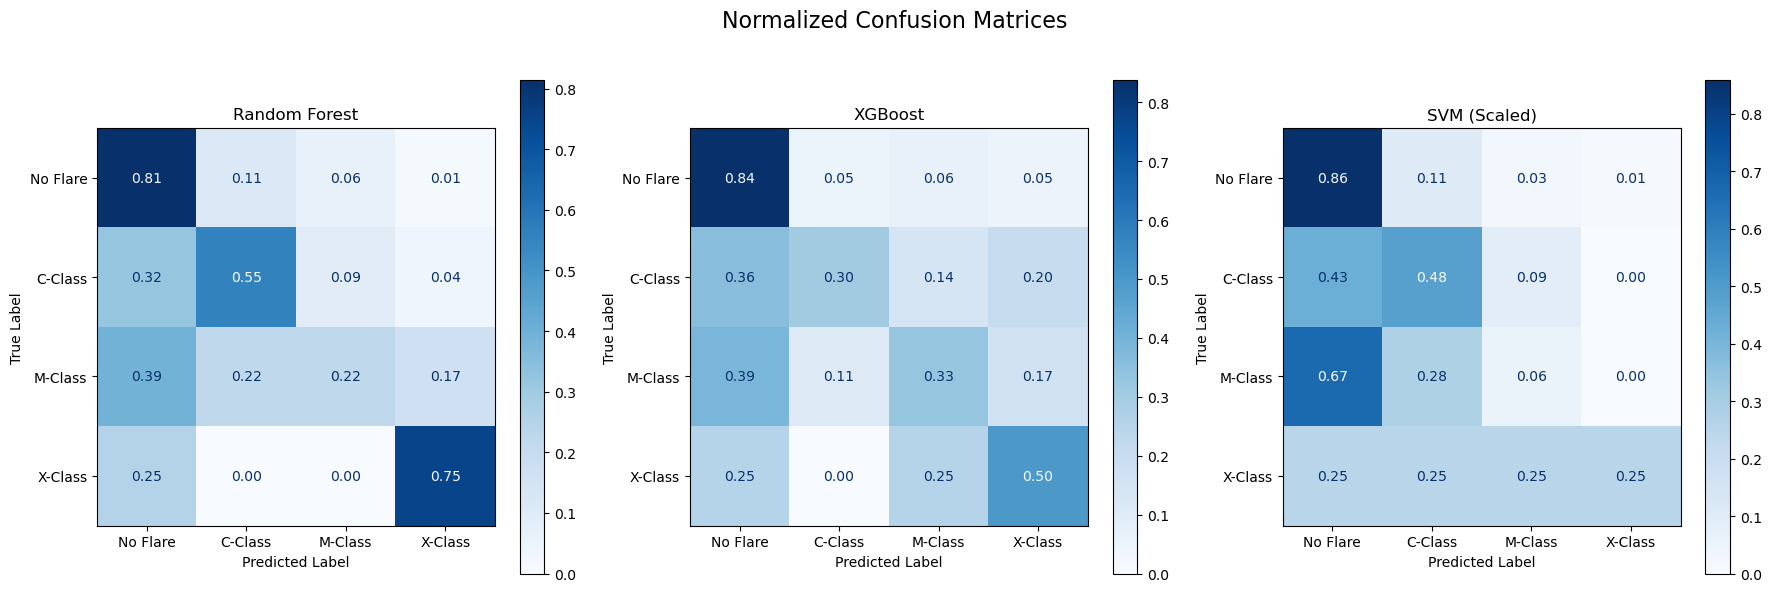

In [19]:
# Define model predictions and class names
model_preds = {
    "Random Forest": rf_test_pred,
    "XGBoost": xgb_test_pred,
    "SVM (Scaled)": svm_test_pred,
}
model_names = list(model_preds.keys())

# Create subplots for confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Normalized Confusion Matrices", fontsize=16)

# Plot normalized confusion matrix for each model
for i, (name, y_pred) in enumerate(model_preds.items()):
    cmatrix = confusion_matrix(y_test, y_pred, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=class_names)
    disp.plot(ax=axes[i], cmap="Blues", colorbar=True, values_format=".2f")
    axes[i].set_title(f"{name}")
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")

# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 5.3. ROC-AUC Analysis

The ROC curves provide a comprehensive view of each model's discrimination ability across all flare classes, reinforcing Random Forest's superiority for mission-critical predictions. The Area Under the Curve (AUC) scores quantify each model's ability to distinguish between classes, with higher values indicating better discrimination capability.

**Random Forest's Performance**

Random Forest excels in predicting X-class (AUC=0.89) and M-class (AUC=0.70) flares, outperforming both XGBoost and SVM for severe solar events that threaten infrastructure. It also maintains a strong performance for "No Flare" (AUC=0.82) and C-class events (AUC=0.81). This balanced capability across all flare intensities makes Random Forest the optimal model for reliable space weather forecasting across the full spectrum of solar activity.

**Validation of Model Selection**

The ROC analysis confirms Random Forest as the optimal choice for operational deployment. The model's superior performance on M-class (0.70 vs 0.63 vs 0.60) and X-class (0.89 vs 0.75 vs 0.79) predictions directly aligns with our business objectives, where accurate detection of moderate to severe flares provides the greatest operational value for space weather forecasting and infrastructure protection.

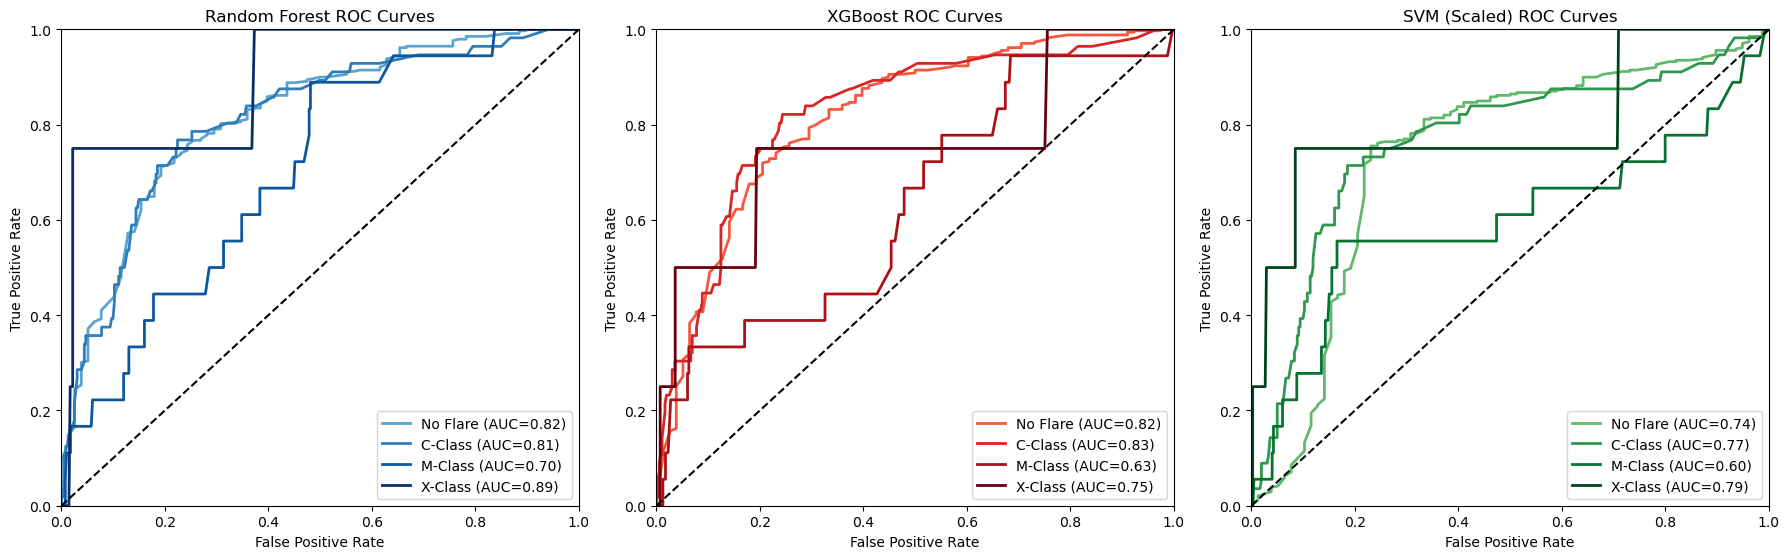

In [20]:
# Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

# Create ROC curves for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
model_data = [
    ("Random Forest", rf_test_proba, cm.Blues),
    ("XGBoost", xgb_test_proba, cm.Reds),
    ("SVM (Scaled)", svm_test_proba, cm.Greens),
]

# Calculate and plot ROC curves for each model
for idx, (model_name, y_score, cmap) in enumerate(model_data):
    ax = axes[idx]
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)

        ax.plot(
            fpr,
            tpr,
            lw=2,
            color=cmap(0.4 + (0.6 * (i + 1) / n_classes)),
            label=f"{class_names[i]} (AUC={roc_auc:.2f})",
        )

    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{model_name} ROC Curves")
    ax.legend(loc="lower right")

# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 5.4. Model Interpretation

SHAP (SHapley Additive exPlanations) analysis provides crucial insights into how our Random Forest model makes X-class flare predictions. This interpretability helps us understand the physical relationships the model has learned from sunspot data.

**Key Feature Drivers for X-Class Flare Prediction**

The SHAP analysis confirms that `largest spot size` is the single most important predictor for X-class flares, with larger spots (high feature values, shown in red) consistently driving predictions toward higher X-class probability.

The `historically-complex` feature shows strong influence, where historically complex regions decrease X-class prediction probability. This suggests that historically complex regions may have already released their stored magnetic energy through previous flare events, leaving them in a lower risk state.

The `spot distribution` characteristic shows that compact configurations (high values) generally contribute positively to X-class predictions, while dispersed configurations (low values) reduce X-class likelihood. This confirms the physical intuition that concentrated magnetic energy in compact sunspot groups creates conditions favorable for explosive flare events.

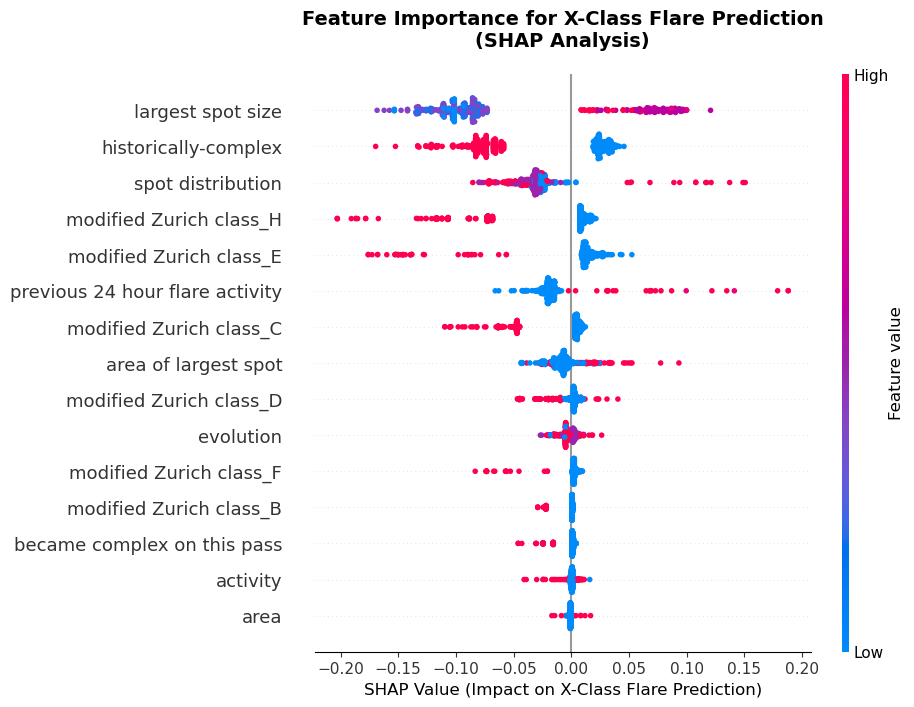

In [21]:
# Create a SHAP explainer using our trained Random Forest model
explainer = shap.Explainer(rf_model)

# Calculate SHAP values specifically for X-class flare predictions (index 3)
shap_values = explainer(X_test)[:, :, 3]

# Generate a beeswarm plot
plt.figure(figsize=(20, 8))
shap.plots.beeswarm(shap_values, max_display=15, show=False)
plt.title(
    "Feature Importance for X-Class Flare Prediction\n(SHAP Analysis)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
plt.xlabel("SHAP Value (Impact on X-Class Flare Prediction)", fontsize=12)
plt.show()

## 6. Deployment



### 6.1. Interactive Solar Flare Prediction System

**Instructions:** Select the characteristics that apply to your sunspot group and click the "Predict Flare Risk" button to get a prediction.

**Characteristics:**

1. **Modified Zurich class:** Magnetic complexity (B=simple → F=complex, H=decayed)
2. **Largest spot size:** Size of largest spot (X=smallest → K=largest)
3. **Spot distribution:** Compactness (X=dispersed → C=compact)
4. **Activity:** Recent growth (1=decay, 2=no change)
5. **Evolution:** 24-hour evolution (1=decay, 2=no growth, 3=growth)
6. **Previous 24 hour flare activity:** Prior flare activity (1=none, 2=one M1, 3=>one M1)
7. **Historically complex:** Ever historically complex (1=Yes, 2=No)
8. **Became complex on this pass:** Became complex on current transit (1=Yes, 2=No)
9. **Area:** Total sunspot group area (1=small, 2=large)
10. **Area of largest spot:** Largest individual spot area (1=≤5, 2=>5)

**Risk Levels:** No Flare (Low) → C-Class (Moderate) → M-Class (High) → X-Class (Critical)

**Example High-Risk Scenario:** Try setting Zurich Class to 'F', Largest Spot Size to 'K', Spot Distribution to 'C', and Previous 24 hour flare activity to 'One M1'.

In [22]:
# Create widgets for each feature
zurich_widget = widgets.SelectionSlider(
    options=category_orders["modified Zurich class"],
    value="C",
    description="Zurich Class:",
    disabled=False,
    style={"description_width": "initial"},
    layout={"width": "300px"},
)

spot_size_widget = widgets.SelectionSlider(
    options=category_orders["largest spot size"],
    value="R",
    description="Largest Spot Size:",
    disabled=False,
    style={"description_width": "initial"},
    layout={"width": "300px"},
)

distribution_widget = widgets.SelectionSlider(
    options=category_orders["spot distribution"],
    value="O",
    description="Spot Distribution:",
    disabled=False,
    style={"description_width": "initial"},
    layout={"width": "300px"},
)

evolution_widget = widgets.SelectionSlider(
    options=["Decay", "No Growth", "Growth"],
    value="No Growth",
    description="Evolution:",
    disabled=False,
    layout={"width": "300px"},
)

flare_activity_widget = widgets.SelectionSlider(
    options=["None", "One M1", ">One M1"],
    value="None",
    description="Previous 24h Flare:",
    disabled=False,
    style={"description_width": "initial"},
    layout={"width": "300px"},
)

activity_widget = widgets.RadioButtons(
    options=["Decay", "No Change"],
    value="No Change",
    description="Activity:",
    disabled=False,
)

historically_complex_widget = widgets.RadioButtons(
    options=["No", "Yes"],
    value="No",
    description="Historically Complex:",
    disabled=False,
    style={"description_width": "initial"},
)

became_complex_widget = widgets.RadioButtons(
    options=["No", "Yes"],
    value="No",
    description="Became Complex:",
    disabled=False,
    style={"description_width": "initial"},
)

area_widget = widgets.RadioButtons(
    options=["Small", "Large"],
    value="Small",
    description="Area:",
    disabled=False,
)

spot_area_widget = widgets.RadioButtons(
    options=["≤5", ">5"],
    value="≤5",
    description="Largest Spot Area:",
    disabled=False,
    style={"description_width": "initial"},
)

# Prediction button and output
predict_button = widgets.Button(
    description="Predict Flare Risk",
    button_style="primary",
    tooltip="Click to make prediction",
)

output_widget = widgets.HTML(
    value='<div style="padding: 10px; border: 1px solid #ddd; border-radius: 5px; background-color: #f9f9f9;">Select sunspot characteristics above and click "Predict Flare Risk" to get a prediction.</div>'
)


# Function to prepare input data for model
def prepare_input_data():
    # Map categorical values to numerical
    zurich_order = {"B": 0, "C": 1, "D": 2, "E": 3, "F": 4, "H": 5}

    # Create input array
    input_data = np.zeros(15)  # 15 features total after preprocessing

    # Set ordinal features
    input_data[0] = largest_spot_size_order[spot_size_widget.value]
    input_data[1] = spot_distribution_order[distribution_widget.value]

    # Set numerical features
    input_data[2] = 1 if activity_widget.value == "No Change" else 0
    input_data[3] = ["Decay", "No Growth", "Growth"].index(evolution_widget.value) + 1
    input_data[4] = ["None", "One M1", ">One M1"].index(flare_activity_widget.value) + 1
    input_data[5] = 1 if historically_complex_widget.value == "Yes" else 0
    input_data[6] = 1 if became_complex_widget.value == "Yes" else 0
    input_data[7] = 1 if area_widget.value == "Large" else 0
    input_data[8] = 1 if spot_area_widget.value == ">5" else 0

    # One-hot encode Zurich class (features 9-14)
    zurich_idx = zurich_order[zurich_widget.value]
    if zurich_idx < 6:
        input_data[9 + zurich_idx] = 1

    return input_data.reshape(1, -1)


# Prediction function
def make_prediction(button):
    try:
        # Prepare input data
        input_data = prepare_input_data()

        # Make prediction using Random Forest
        prediction = rf_model.predict(input_data)[0]
        probabilities = rf_model.predict_proba(input_data)[0]

        # Map prediction to class names
        predicted_class = class_names[prediction]
        confidence = probabilities[prediction] * 100

        # Create color coding for different risk levels
        if prediction == 0:
            color = "#28a745"  # Green for no flare
            risk_level = "LOW"
        elif prediction == 1:
            color = "#ffc107"  # Yellow for C-class
            risk_level = "MODERATE"
        elif prediction == 2:
            color = "#fd7e14"  # Orange for M-class
            risk_level = "HIGH"
        else:  # X-class
            color = "#dc3545"  # Red for X-class
            risk_level = "CRITICAL"

        # Format probability breakdown
        prob_breakdown = "<br>".join(
            [
                f"{class_names[i]}: {probabilities[i] * 100:.1f}%"
                for i in range(len(class_names))
            ]
        )

        # Create formatted output
        output_html = f"""
        <div style="padding: 15px; border: 2px solid {color}; border-radius: 8px; background-color: #fff;">
            <h3 style="color: {color}; margin-top: 0;">Prediction Results</h3>
            <div style="font-size: 18px; margin-bottom: 10px;">
                <strong>Predicted Class:</strong> <span style="color: {color}; font-weight: bold;">{predicted_class}</span>
            </div>
            <div style="font-size: 16px; margin-bottom: 10px;">
                <strong>Risk Level:</strong> <span style="color: {color}; font-weight: bold;">{risk_level}</span>
            </div>
            <div style="font-size: 14px; margin-bottom: 10px;">
                <strong>Confidence:</strong> {confidence:.1f}%
            </div>
            <div style="font-size: 12px; color: #666;">
                <strong>Probability Breakdown:</strong><br>
                {prob_breakdown}
            </div>
        </div>
        """

        output_widget.value = output_html

    except Exception as e:
        output_widget.value = f'<div style="padding: 10px; border: 1px solid #dc3545; border-radius: 5px; background-color: #f8d7da; color: #721c24;">Error making prediction: {str(e)}</div>'


# Connect button to prediction function
predict_button.on_click(make_prediction)

# Create layout with each widget on its own line for better clarity
physics_section = widgets.VBox(
    [
        widgets.HTML(
            '<h4 style="margin-bottom: 4px; color: #2c3e50;">Magnetic and Physical Characteristics</h4>'
        ),
        zurich_widget,
        widgets.HTML('<div style="margin: 4px 0;"></div>'),
        spot_size_widget,
        widgets.HTML('<div style="margin: 4px 0;"></div>'),
        distribution_widget,
    ],
    layout={"width": "600px"},
)

area_section = widgets.VBox(
    [
        widgets.HTML(
            '<h4 style="margin-bottom: 4px; color: #2c3e50;">Area Measurements</h4>'
        ),
        widgets.HBox(
            [
                area_widget,
                spot_area_widget,
            ]
        ),
    ]
)

activity_section = widgets.VBox(
    [
        widgets.HTML(
            '<h4 style="margin-bottom: 8x; color: #2c3e50;">Recent Activity and Evolution</h4>'
        ),
        widgets.HBox(
            [
                activity_widget,
                widgets.VBox(
                    [
                        evolution_widget,
                        widgets.HTML('<div style="margin: 4px 0;"></div>'),
                        flare_activity_widget,
                    ]
                ),
            ]
        ),
    ]
)

complexity_section = widgets.VBox(
    [
        widgets.HTML(
            '<h4 style="margin-bottom: 4px; color: #2c3e50;">Complexity Indicators</h4>'
        ),
        widgets.HBox(
            [
                historically_complex_widget,
                became_complex_widget,
            ]
        ),
    ]
)

prediction_section = widgets.VBox(
    [predict_button, widgets.HTML('<div style="margin: 4px 0;"></div>'), output_widget]
)

# Main interface layout with better spacing
main_interface = widgets.VBox(
    [
        widgets.HBox(
            [
                physics_section,
                area_section,
            ]
        ),
        activity_section,
        complexity_section,
        prediction_section,
    ],
    layout={"padding": "20px", "max_width": "800px"},
)

# Display the interface
display(HTML('<div style="padding: 10px; background: purple; border-radius: 10px; text-align: center; max-width: 800px;"><h2 style="color: white; margin: 0;">Solar Flare Prediction System</h2></div>'))
display(main_interface)

### 6.2. Deployment Recommendations

For operational deployment, the Random Forest model can be implemented through cloud infrastructure with auto-scaling capabilities to handle varying demands during different solar cycle phases. Integration with existing space weather forecasting centers would enable real-time predictions through API endpoints.

**Phased Implementation:**
- **Phase 1:** Advisory predictions alongside existing methods
- **Phase 2:** Primary operational deployment with human oversight
- **Phase 3:** Automated alerting with configurable thresholds

The system should include continuous monitoring for model performance drift and provide retraining capabilities as new solar data becomes available. Operational staff will require training on model interpretation and confidence intervals to effectively use the prediction outputs for critical infrastructure protection decisions.

### 6.3. Conclusions

This machine learning analysis successfully developed solar flare prediction models using a dataset of 1,389 sunspot observations. Despite significant data challenges, we achieved meaningful predictive capability with our final Random Forest model.

**Model Performance Results:**

Our Random Forest model achieved the strongest overall performance with:
- **Macro F1-score: 0.471** (best among all three models tested)
- **X-class flare recall: 75%** (meeting our critical success criterion of >60%)
- **Overall accuracy: 76.5%** on the holdout test set
- **ROC-AUC: 0.806** indicating strong discrimination capability

**Key Technical Challenges:**

The most prominent challenges were the small dataset size of only 1,389 total observations (further reduced by train/test splitting) and the extreme class imbalance with X-class flares representing merely 1% of cases. The combination of these two factors meant our models had insufficient examples of X-class flares (14 total cases) to learn predictive patterns.

Additional challenges included:
- M-class flare prediction difficulty (17-33% correct classification across models)
- Limited feature set with only 10 input variables

**Model Selection Rationale:**

Random Forest was selected as the optimal model based on:
1. **Superior X-class recall (75%)** - critical for minimizing missed severe events
2. **Highest macro F1-score (0.471)** - balanced performance across all classes  
3. **Strong feature interpretability** through SHAP analysis
4. **Robust ROC-AUC performance** for both M-class (0.70) and X-class (0.89) predictions

**Key Feature Insights:**

SHAP analysis revealed that `largest spot size` is the most important predictor for X-class flares, followed by `spot distribution` (compact configurations increase risk) and `historically-complex` status (surprisingly shows inverse relationship).

**Technical Limitations:**

While achieving our primary success criteria, the model's moderate F1-macro score (0.471) indicates substantial room for improvement. The consistent difficulty across all algorithms in predicting M-class flares suggests these events may lack distinctive characteristics in our current feature set, representing the most challenging prediction category in solar flare prediction.